# Intermediate notebook 3: stellar rotation rates part 2

In [2]:
# manipulating and plotting arrays
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import seaborn as sns
import pandas as pd

# file handling and units
import tarfile
from tqdm import tqdm
import astropy
from astropy.io import fits
import astropy.constants as const
import astropy.units as u
from astropy.utils.data import download_file
from lightkurve.search import search_lightcurve
from numba import njit

# machine learning and data packages

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from sklearn import metrics
import scipy

# now need to set up the sampling
import emcee

#setting random seeds
seed = 42
np.random.seed(seed)
import os
os.environ['PYTHONHASHSEED']=str(seed)
import random
random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)

# read from cloud datasets as opposed to downloading from on-premise servers
from astroquery.mast import Observations
Observations.enable_cloud_dataset()

# gaussian process packages
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
import arviz as az
import corner



%matplotlib inline

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


In [3]:
!pip install celerite2

  Using cached celerite2-0.2.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (921 kB)


In [7]:
from celerite2.theano import terms, GaussianProcess

# Exercise 3

In [ ]:
stars = np.loadtxt('stars.txt')

In [ ]:
# if loading back in after performing the computations
rot_rates_gp = []
# iterate though stars
for star in tqdm(stars[::200]):
    star_name = str(star) # the rotation rate function takes strings
    data = np.load(f'period_samples{int(eval(star_name))}.npy')
    rot_rates_gp += [data]

In [18]:
@njit
def f_rotation_flat(b, flare): # just a log-linear functional form
    """
    this is the function that returns the LOG rotation rate.
    """
    return b

# todo: redo as the half gaussian

In [19]:
@njit
def updated_prior_halfgauss(rotation_inferred, b, flare_rate, sigma_2):
    # this is P_alpha
    # this should probably be log difference, right
    # mu = np.log10(rotation_inferred) - f_rotation(m, b, flare_rate) # the sample - the calculated trend. 
    sigma = sigma_2
    # pdb.set_trace()
    # return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(np.log10(rotation_inferred)-mu)**2/sigma**2 
    return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(np.log10(rotation_inferred)-f_rotation_flat(b, flare_rate))**2/sigma**2 

@njit
def likelihood_hierarchical_halfgauss(samples, b, sigma_2, flare_rates_durations_cleaned, rot_rates_constrained):
    """
    the regular prior was normal in log period
    """
    total_likelihood = 1.
    # looping over whole populatio
    for i, rotations_inferred in enumerate(samples):
        # right now looping over a single planet's retrieved rotation rate
        likelihood = 0.
        flare_rate = flare_rates_durations_cleaned[i]
        period_guess = rot_rates_constrained[i]
        for rotation_inferred in rotations_inferred:
            updated_prior_val = np.exp(updated_prior_flat(rotation_inferred, b, flare_rate, sigma_2))
            previous_prior_val = np.exp(previous_prior(rotation_inferred, period_guess))
            prior_update = updated_prior_val / previous_prior_val
            likelihood += prior_update
            # if np.isnan(likelihood):
            #     pdb.set_trace()
            # if likelihood < 0:
            #     pdb.set_trace()
        total_likelihood *= likelihood / len(rotations_inferred)
    
    return np.log(total_likelihood)

@njit
def posterior_hierarchical_halfgauss(hypertheta, samples, flare_rates_durations_cleaned, rot_rates_constrained):
    b, sigma_2 = hypertheta
    # likelihood * P_a
    
    hyperprior_val = hyperprior_flat(hypertheta)
    
    if not np.isfinite(hyperprior_val):
        return -np.inf
    
    # error maybe in likelihood func
    likelihood_val = likelihood_hierarchical_flat(samples, b, sigma_2, flare_rates_durations_cleaned, rot_rates_constrained)
    
    # if np.isnan(likelihood_val):
    #     pdb.set_trace()
    return likelihood_val + hyperprior_val


# we have all of these. now do a hyperprior.
@njit
def hyperprior_halfgauss(hypertheta):
    b, sigma_2 = hypertheta
    if not (-10 < b < 10 and sigma_2 > 0.2):
        return -np.inf

    
    #gaussian prior on sigma_2
    mu = 0
    sigma = 1
    return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(sigma_2-mu)**2/sigma**2

In [ ]:
n_dim = 2
n_walkers = 32 # seems fine. justify?
n_steps = 5000 # seems fine. justify?


initial_point = np.array([np.mean(np.log10(rot_rates_gp_sorted)), .5]) # incorporate as an array and not a list so that we can add to it, etc.
gaussian_scatter_level = 1e-3 # seems fine. justify?

# add some scatter to the walkers around the initial position.
pos = initial_point + gaussian_scatter_level * np.random.randn(n_walkers, n_dim)



sampler = emcee.EnsembleSampler(
    n_walkers, n_dim, posterior_hierarchical_halfgauss, args=(rot_rates_gp_sorted, flare_rates_durations_sorted,
                                                    rot_rates_constrained_sorted)
)
sampler.run_mcmc(pos, n_steps, progress=True);

In [ ]:
fig, axes = plt.subplots(n_dim, figsize=(10, 3), sharex=True)
samples = sampler.get_chain()
labels = ['m', 'b', 'sigma']

for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

In [ ]:
flat_samples_flat = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

In [ ]:
fig = corner.corner(
    flat_samples_flat, labels=labels
);

In [ ]:
dat = pd.DataFrame({'flare':np.repeat(np.log10(flare_rates_durations_sorted),2000),
              'rot':np.log10(rot_rates_gp_sorted.flatten())})
fig, ax = plt.subplots()
sns.violinplot(
    data=dat,
    x="flare", y="rot", hue=True,
    hue_order=[True, False], split=True, scale_hue=12,color='teal',ax=ax
)
ax.legend_ = None
ax.set_xticks([0.,10, 21], [0.6, 0.7, 0.8])
# ax.set_yscale('log')
ax.set_xlabel('Log flare rate (per day)', fontsize=18)
ax.set_ylabel('Log rotation date (days)', fontsize=18)

inds = np.random.randint(len(flat_samples_flat), size=100)
for ind in inds:
    sample = flat_samples_flat[ind]
    ax.plot(20 * (np.log10(flare_rates_durations_sorted) -0.58708446)/ (0.83866827 - 0.58708446), (np.dot(np.vander(np.log10(flare_rates_durations_sorted), 2), sample[:2])), "C1", alpha=0.1)
# ax.errorbar(np.log10(flare_rates_durations_sorted)* 21/0.8,np.log10(np.mean(rot_rates_gp_sorted, axis=1)),
#             yerr=yerr/np.mean(rot_rates_gp_sorted, axis=1) / np.log(10),)




In [ ]:
def calc_bic(log_likelihood, n_points, n_params):
    """
    calculates the Bayesian Information Criterion.
    """
    bic = -2 * log_likelihood + np.log(n_points) * n_params
    return bic

In [ ]:
# todo: save the flat line BIC for comparison

n_points = len(rot_rates_gp_sorted)


# trend line likelihood
flat_chain_mean = np.mean(flat_samples, axis=0)
log_likelihood_trend = likelihood_hierarchical(rot_rates_gp_sorted, flat_chain_mean[0],
                                               flat_chain_mean[1],
                                               flat_chain_mean[2],
                                               flare_rates_durations_sorted,
                                                    rot_rates_constrained_sorted)


# flat line likelihood
flat_chain_flat_mean = np.mean(flat_samples_flat, axis=0)
log_likelihood_flat = likelihood_hierarchical_flat(rot_rates_gp_sorted, 
                                                   flat_chain_flat_mean[0], 
                                                   flat_chain_flat_mean[1], 
                                                   flare_rates_durations_sorted,
                                                    rot_rates_constrained_sorted)


# do delta BIC calculation
bic_trend = calc_bic(log_likelihood_trend, n_points, 3)
bic_flat = calc_bic(log_likelihood_flat, n_points, 2)

delta_bic = bic_trend - bic_flat
delta_bic

# Exercise 4

To solve this exercise, we'll essentially set up the same sampling as we performed in the main notebook. However, we'll just run the sampler a little longer and see if reaching convergence changes our answers very much.

(1325.0, 1335.0)

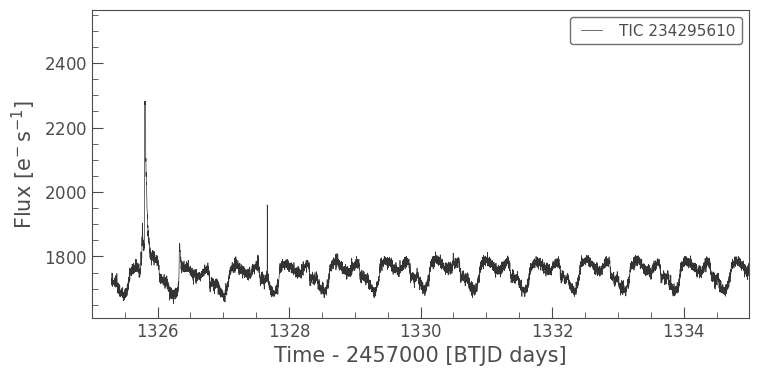

In [4]:
ticids = ['234295610']

# for all the selected targets, pull the available lightcurves using the lightkurve package
sectors = [1, 2] # only consider the first few sectors
lcs = []
for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
lc.plot()
plt.xlim(1325, 1335)

In [5]:
lc2 = lc.remove_nans().remove_outliers()
lc2 = lc2[:5000]
_, mask = lc2.flatten().remove_outliers(sigma=3.0, return_mask=True)
lc2 = lc2[~mask]

x = np.ascontiguousarray(lc2.time.value, dtype=np.float64)
y = np.ascontiguousarray(lc2.flux, dtype=np.float64)
yerr = np.ascontiguousarray(lc2.flux_err, dtype=np.float64)
mu = np.mean(y)

# center the flux around 0 for probabilistic modeling
y = (y / mu - 1) * 1e3

# perform error propagation
yerr = yerr * 1e3 / mu

In [8]:
with pm.Model() as model:
    # The mean function.
    mean = pm.Normal("mean", mu=0.0, sigma=10.0)

    # A jitter term describing excess white noise
    log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sigma=2.0)

    # A term to describe the non-periodic variability
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
    )

    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    log_period = pm.Normal("log_period", mu=np.log(0.76), sigma=2.0)
    period = pm.Deterministic("period", tt.exp(log_period))
    log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
    log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
    f = pm.Uniform("f", lower=0.1, upper=1.0)

    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
    kernel += terms.RotationTerm(
        sigma=sigma_rot,
        period=period,
        Q0=tt.exp(log_Q0),
        dQ=tt.exp(log_dQ),
        f=f,
    )
    gp = GaussianProcess(
        kernel,
        t=x,
        diag=yerr**2 + tt.exp(2 * log_jitter),
        mean=mean,
        quiet=True,
    )

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(y))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize(progress=True)

optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -17797.54833147572 -> -15571.358082651843


In [ ]:
#setting random seeds
seed = 42
np.random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
tf.random.set_seed(seed)

seed1 = 10862087
seed2 = 10862088

with model:
    trace = pmx.sample(
        tune=1500,
        draws=2000,
        start=map_soln,
        cores=4,
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[seed1, seed2],
        progressbar=True
    )

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


In [ ]:
divergent = short_trace["diverging"]
print("Number of Divergent %d" % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(short_trace) * 100
print("Percentage of Divergent %.1f" % divperc)

In [16]:
az.summary(
    trace,
    var_names=[
        "f",
        "log_dQ",
        "log_Q0",
        "log_period",
        "sigma_rot",
        "rho",
        "sigma",
        "log_jitter",
        "mean",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
f,0.430,0.239,0.160,0.911,0.102,0.076,6.0,82.0,1.22
log_dQ,-0.551,1.769,-4.115,3.034,0.628,0.461,7.0,54.0,1.58
log_Q0,3.572,2.516,0.000,7.196,1.329,1.029,4.0,12.0,1.54
log_period,-0.943,0.046,-0.986,-0.828,0.022,0.017,4.0,12.0,1.69
sigma_rot,9.943,6.082,2.611,21.907,4.008,3.299,3.0,12.0,2.12
rho,0.417,0.274,0.246,1.028,0.135,0.103,5.0,12.0,1.92
sigma,14.770,5.623,1.191,19.085,3.126,2.447,6.0,12.0,1.44
log_jitter,-1.073,0.881,-2.820,0.025,0.290,0.212,9.0,1004.0,1.16
mean,-0.180,2.450,-5.125,4.750,0.202,0.468,65.0,74.0,1.58


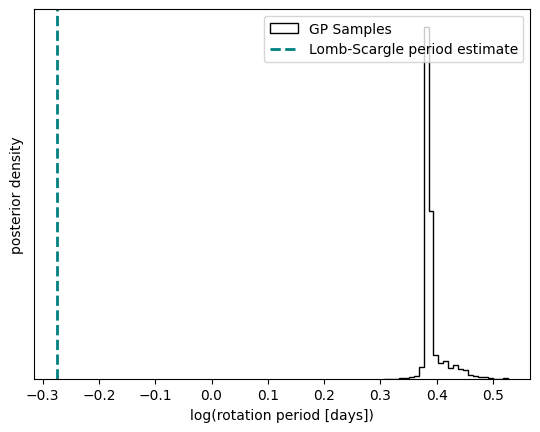

In [17]:
period_samples = np.asarray(trace.posterior["period"]).flatten()
plt.hist(period_samples, 25, histtype="step", color="k", density=True, label='GP Samples')
plt.yticks([])
plt.xlabel("log(rotation period [days])")
plt.axvline(np.log(0.76), color='teal', linestyle='--', lw=2, label='Lomb-Scargle period estimate')
_ = plt.ylabel("posterior density")
plt.legend()